In [201]:
%matplotlib inline

import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

## FUNCTIONS

In [202]:
def readVideoFrames(filename):
    vid = imageio.get_reader(filename,  'ffmpeg')
    fps = vid.get_meta_data()['fps']
    num = 0
    frames = []
    while 1:
        try:
            image = vid.get_data(num)
            frames.append(image)
            num+=1
        except IndexError:
            break

    return np.array(frames), fps

In [203]:
def makeGrayScale(rgbVid):
    '''Converts numpy array vid to grayscale vid'''
    frames_bw = []
    for frame in rgbVid:
        frames_bw.append(np.around(np.dot(frame[:,:,:3], [0.2989, 0.587, 0.114])))
    return np.array(frames_bw)

In [204]:
def calculateDifferenceFrames(frames):
    dif_lst = []
    for i in range(1, frames.shape[0]):
        dif_lst.append(frames[i-1,:,:]-frames[i,:,:])
    return np.array(dif_lst)

In [205]:
def divideToMacroblocks(frame, macroblock_size=16):
    macroblocks = []
    m, n = frame.shape
    for i in range(0, m, macroblock_size):
        for j in range(0, n, macroblock_size):
            macroblock = frame[i:i+macroblock_size,j:j+macroblock_size]
    #         print (macroblock.shape)
            if macroblock.shape == (macroblock_size, macroblock_size):
    #             print ('works')
                macroblocks.append(macroblock)
            else:
    #             print ('something\'s goin\' on')
                try:
                    macroblock = np.vstack((macroblock, np.zeros(macroblock.shape[0], macroblock_size-macroblock.shape[1])))
                except TypeError:
                    pass
                try:
                    macroblock = np.hstack((macroblock, np.zeros(macroblock_size-macroblock.shape[0], macroblock.shape[1])))
                except TypeError:
                    pass
                macroblocks.append(macroblock)
    return np.array(macroblocks).reshape((int(m/macroblock_size), int(n/macroblock_size), macroblock_size, macroblock_size))

In [206]:
def createNeighborhood(referenceFrame, indexOfMacroblock, macroblock_size=16, k=16):
    neighborhood = []
#     print (indexOfMacroblock)
    for i in range(indexOfMacroblock[0]-k, indexOfMacroblock[0]+k+1, k):
        for j in range(indexOfMacroblock[1]-k, indexOfMacroblock[1]+k+1, k):
            if (i >= 0 and j >= 0 and i+macroblock_size < referenceFrame.shape[0] and j+macroblock_size < referenceFrame.shape[1]):
#                 print (i,j)
                neighborhood.append(referenceFrame[i:i+macroblock_size, j:j+macroblock_size])
            else:
                neighborhood += [None]
    return neighborhood

In [207]:
def SAD(referenceMacroblock, targetMacroblock):
#     print (targetMacroblock.shape, referenceMacroblock.shape)
    return np.sum(np.abs(targetMacroblock - referenceMacroblock))

In [208]:
def calculateSAD(targetMacroblock, referenceFrame_neighbor_macroblocks):
    SADvals = []
        
    for macroblock in referenceFrame_neighbor_macroblocks:
        if macroblock is not None:
            SADvals.append(SAD(macroblock, targetMacroblock))
        else:
            SADvals.append(np.Inf)
    
    return np.array(SADvals).reshape((3,3))

In [209]:
def logarithmicSearch(referenceFrame, targetMacroblock, indexOfMacroblock, macroblock_size=16, k=16):
    if (k == 0):
        return indexOfMacroblock, referenceFrame[indexOfMacroblock[0]:indexOfMacroblock[0]+macroblock_size, indexOfMacroblock[1]:indexOfMacroblock[1]+macroblock_size] # motionVector END (To_WIDTH, To_HEIGHT), return Predicted Frame
    
    referenceFrame_neighbor_macroblocks = createNeighborhood(referenceFrame, indexOfMacroblock, macroblock_size, k)

    SAD_values = calculateSAD(targetMacroblock, referenceFrame_neighbor_macroblocks)
#     print (SAD_values)
    indexofMinimumSAD = divmod(SAD_values.argmin(), SAD_values.shape[1])
    newIndexOfMacroblock = list(indexOfMacroblock)
    
    if (indexofMinimumSAD[0] == 0):
        newIndexOfMacroblock[0] = indexOfMacroblock[0] - k
    elif (indexofMinimumSAD[0] == 2):
        newIndexOfMacroblock[0] = indexOfMacroblock[0] + k
    
    if (indexofMinimumSAD[1] == 0):
        newIndexOfMacroblock[1] = indexOfMacroblock[1] - k
    elif (indexofMinimumSAD[1] == 2):
        newIndexOfMacroblock[1] = indexOfMacroblock[1] + k

    if (indexofMinimumSAD[0] == 1 and indexofMinimumSAD[1] == 1):
        newK = k//2
    else:
        newK = k       
#     print (indexofMinimumSAD)
#     print (newIndexOfMacroblock)
    return logarithmicSearch(referenceFrame, targetMacroblock, tuple(newIndexOfMacroblock), macroblock_size, newK)

In [210]:
def motionCompensation(referenceFrame, targetFrame, macroblock_size=16):
    predictedBlocks = []
    motionVectors = []
    
    targetMacroblocks = divideToMacroblocks(targetFrame, macroblock_size)
    for i in range(targetMacroblocks.shape[0]):
        for j in range(targetMacroblocks.shape[1]):
            motionVectorSTART = (i*macroblock_size, j*macroblock_size)
            indexofBlock = (i*macroblock_size, j*macroblock_size)
            motionVectorEND, prediction = logarithmicSearch(referenceFrame, targetMacroblocks[i,j,:,:], indexofBlock)
            predictedBlocks.append(prediction)
            motionVectors.append(motionVectorSTART+motionVectorEND)

#     print (len(motionVectors))
    predictedBlocks = np.array(predictedBlocks).reshape(targetMacroblocks.shape)
    motionVectors = np.array(motionVectors, dtype=(int,4)).reshape((targetMacroblocks.shape[0], targetMacroblocks.shape[1], 4))
    return predictedBlocks, motionVectors

In [211]:
def imageReconstructFromBlocks(blocks):
    lines = []
    for i in range(blocks.shape[0]):
        line = []
        for j in range(blocks.shape[1]):
            line.append(blocks[i,j,:,:])
        line = np.hstack(line)
        lines.append(line)
    return np.vstack(lines)

In [212]:
def find_moving_object(lst): #V2 - the input arguments have changed!!!
    X = np.array(lst)
    q25_75 = np.array([])
    
    outliers_list_batch = []
    
    if len(X.shape) ==1:
        X = X.reshape((X.shape[0],1))


    if not q25_75.any():
        q25_75 = np.zeros((X.shape[1],2))	#V3 - changed X.shape[0] to X.shape[1]
    for line in range(X.shape[1]):
    #     if line%300==0:
    #         print 'lines processed: ', line, ' out of ', X.shape[1]
        x = X[:,line].copy()        
        outliers_list = []

        if sum(abs(x))!=0:
            q25=q25_75[line,0]
            q75=q25_75[line,1]

            if (q25==0) & (q75==0):
                q75, q25 = np.percentile(x[x!=0], [75,25])

            iqr = q75 - q25
            outl = np.argwhere(abs(x)>q75+3*iqr)
            outliers = group_consecutives(outl)
            for ll in outliers:
                if ll:
                    current = int(ll[0][0]),int(ll[-1][0])
                    outliers_list.append(current)        
        else:
            outliers_list.append([])
            q75 = 0
            q25 = 0

        outliers_list_batch.append(outliers_list)
        q25_75[line,:] = [q25,q75]
        
    fn_lst = []
    for i in range(outliers_list_batch[0][0][0], outliers_list_batch[0][0][1]):
        fn_lst.append(tuple(lst[i][1:]))
    # print 'done.'
    return fn_lst

In [213]:
def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result

In [214]:
def make_var_list(mbs):
    lst = []
    for y, macby in enumerate(mbs):
        for x, macbx in enumerate(macby):
            lst.append((max(pd.DataFrame(macbx).max()-pd.DataFrame(macbx).min()), y, x))
            
    return lst

In [215]:
def swap_object(x_and_y, frame, back):
    tmp = frame
    for tup in x_and_y:
        y,x = tup
        tmp[y][x] = back[y][x]
        
    return tmp

In [216]:
def reconstruct_vid(img1, diffs):
    final_vid  = [img1]
    cnt = 1
    for frame in diffs:
        final_vid.append(final_vid[-1]-frame)
        
    
    return np.array(final_vid)

In [217]:
def find_obj(diff):
    mc = divideToMacroblocks(diff,8)
    lst = make_var_list(mc)
    lst.sort(key=lambda x: x[0])
    outs = find_moving_object(lst)
    return outs

In [218]:
def has_n_neighbor(point, lst, num=1):
    neighs = []
    for cand in lst:
        if abs(cand[0]-point[0])<=1 and abs(cand[1]-point[1])<=1 and point != cand:
            neighs.append(cand)
            
    if len(neighs)>=num:
        return True
    else:
        return False
        
        

In [219]:
def return_range(lst, min_neighs=1):
    neighs=  []
    final_range = []
    for point in lst:
        if has_n_neighbor(point, lst, num=min_neighs):
            neighs.append(point)
    
    xs, ys = [val[0] for val in neighs], [val[1] for val in neighs]
    
    if len(xs)==0 or len(ys)==0:
        return []
    for i in range(min(xs), max(xs)+1):
        for j in range(min(ys), max(ys)+1):
            final_range.append((i,j))
            
    return final_range

## Main

In [220]:
hall_monitor_cif = "resources/ex617/hall_monitor_cif.y4m"
resources_path = "resources/ex818"

In [221]:
videoFrames, fps = readVideoFrames(hall_monitor_cif)

In [222]:
videoFramesSample = videoFrames[:, :, :, :]
videoFramesSample.shape

(300, 288, 352, 3)

In [223]:
videoFramesSample = makeGrayScale(videoFramesSample)
videoFramesSample.shape

(300, 288, 352)

In [238]:
finalVideoFramesSample = [videoFramesSample[0]]
mb_back = divideToMacroblocks(videoFramesSample[0], 8)
mbs = [[],[],[]]
FrameDifferenceSample = calculateDifferenceFrames(videoFramesSample)
for cnt, frame in enumerate(FrameDifferenceSample):
    moving_mbs = find_obj(frame)
    final_mbs = return_range(moving_mbs)
    mb_new = divideToMacroblocks(videoFramesSample[cnt+1],8)
    full_mb = set(final_mbs+mbs[-1]+mbs[-2]+mbs[-3])
    new_frame = swap_object(final_mbs,mb_new, mb_back)
    final_img = imageReconstructFromBlocks(new_frame)
    finalVideoFramesSample.append(final_img)
    mbs.append(final_mbs)


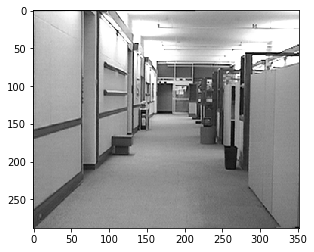

In [225]:
plt.imshow(finalVideoFramesSample[50], cmap='gray')

In [237]:
a = []

a[-2]

IndexError: list index out of range

In [228]:
a= [(0,1),(1,1)]
b = [(0,1), (2,2)]

c = set(a+b)

In [229]:
c

{(0, 1), (1, 1), (2, 2)}

In [227]:
moving_mbs

[(19, 30),
 (21, 29),
 (26, 33),
 (9, 20),
 (10, 18),
 (13, 31),
 (14, 16),
 (15, 28),
 (26, 34),
 (10, 0),
 (20, 13),
 (7, 36),
 (22, 28),
 (3, 13),
 (7, 34),
 (10, 14),
 (10, 30),
 (10, 31),
 (9, 32),
 (15, 33),
 (23, 34),
 (21, 30),
 (11, 31),
 (26, 29),
 (18, 30),
 (22, 32),
 (22, 34),
 (18, 29),
 (9, 19),
 (14, 33),
 (15, 31),
 (17, 32),
 (19, 29),
 (26, 28),
 (27, 34),
 (16, 31),
 (17, 29),
 (11, 32),
 (15, 32),
 (25, 28),
 (17, 30),
 (24, 28),
 (23, 33),
 (20, 34),
 (15, 30),
 (27, 35),
 (16, 29),
 (16, 32),
 (22, 30),
 (17, 31),
 (19, 34),
 (22, 29),
 (22, 33),
 (25, 29),
 (22, 31),
 (23, 29),
 (16, 30),
 (18, 33),
 (35, 21),
 (21, 31),
 (23, 28),
 (17, 33),
 (21, 34),
 (10, 32),
 (13, 32),
 (23, 31),
 (13, 33),
 (12, 31),
 (15, 29),
 (12, 30),
 (24, 30),
 (11, 33),
 (24, 29),
 (13, 29),
 (10, 33),
 (14, 30),
 (19, 33),
 (23, 30),
 (12, 32),
 (14, 29),
 (13, 30)]

compensatedVideoFramesSample = [videoFramesSample[0]]
motionVectors = []
cnt = 1
for prevFrame, nextFrame in zip(videoFramesSample, videoFramesSample[1:]):
    
    prediction, vectors = motionCompensation(prevFrame, nextFrame)
    diff = compensatedVideoFramesSample[-1]-imageReconstructFromBlocks(prediction)
    
    mcbs = divideToMacroblocks(diff)
    npred = swap_object(find_moving_object(mcbs), prediction, compensatedVideoFramesSample[0])
    
    predFrame = imageReconstructFromBlocks(npred)
    compensatedVideoFramesSample.append(predFrame)
    motionVectors.append(vectors) 
    if cnt == 6:
        break
    else:
        cnt+=1
    

In [239]:
writer = imageio.get_writer(os.path.join(resources_path,'hall_monitor_cif_exafanizol4.mp4'), fps=fps,mode="I")

for frame in finalVideoFramesSample:
    writer.append_data(frame)
writer.close()

C:\Users\theotheo\Anaconda3\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 255.0]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


In [62]:
tmp = videoFramesSample[90]- videoFramesSample[89]

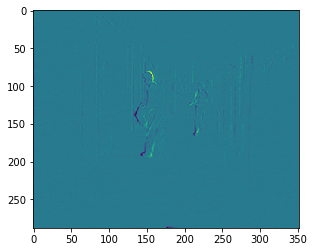

In [63]:
plt.imshow(tmp)

In [140]:
mc = divideToMacroblocks(tmp)

In [141]:
lst = make_var_list(mc)

In [142]:
lst

[(38.0, 0, 0),
 (14.0, 0, 1),
 (10.0, 0, 2),
 (19.0, 0, 3),
 (25.0, 0, 4),
 (30.0, 0, 5),
 (46.0, 0, 6),
 (21.0, 0, 7),
 (13.0, 0, 8),
 (13.0, 0, 9),
 (13.0, 0, 10),
 (13.0, 0, 11),
 (12.0, 0, 12),
 (18.0, 0, 13),
 (14.0, 0, 14),
 (14.0, 0, 15),
 (12.0, 0, 16),
 (15.0, 0, 17),
 (10.0, 0, 18),
 (15.0, 0, 19),
 (16.0, 0, 20),
 (14.0, 0, 21),
 (57.0, 1, 0),
 (13.0, 1, 1),
 (13.0, 1, 2),
 (14.0, 1, 3),
 (30.0, 1, 4),
 (44.0, 1, 5),
 (46.0, 1, 6),
 (40.0, 1, 7),
 (18.0, 1, 8),
 (0.0, 1, 9),
 (30.0, 1, 10),
 (16.0, 1, 11),
 (13.0, 1, 12),
 (13.0, 1, 13),
 (16.0, 1, 14),
 (13.0, 1, 15),
 (14.0, 1, 16),
 (13.0, 1, 17),
 (33.0, 1, 18),
 (13.0, 1, 19),
 (7.0, 1, 20),
 (6.0, 1, 21),
 (27.0, 2, 0),
 (12.0, 2, 1),
 (11.0, 2, 2),
 (15.0, 2, 3),
 (23.0, 2, 4),
 (54.0, 2, 5),
 (17.0, 2, 6),
 (15.0, 2, 7),
 (23.0, 2, 8),
 (21.0, 2, 9),
 (16.0, 2, 10),
 (14.0, 2, 11),
 (15.0, 2, 12),
 (14.0, 2, 13),
 (13.0, 2, 14),
 (13.0, 2, 15),
 (14.0, 2, 16),
 (21.0, 2, 17),
 (8.0, 2, 18),
 (12.0, 2, 19),
 (0.0, 2, 

In [143]:
lst.sort(key=lambda x: x[0])

In [144]:
outs = find_moving_object(lst)

In [145]:
outs

[(8, 9),
 (6, 14),
 (7, 8),
 (10, 9),
 (9, 9),
 (6, 13),
 (7, 9),
 (9, 13),
 (6, 9),
 (12, 9),
 (12, 8),
 (10, 13),
 (7, 12),
 (6, 10),
 (9, 8),
 (11, 9),
 (11, 8),
 (8, 8),
 (5, 10),
 (17, 11),
 (7, 13)]

In [101]:
new = np.zeros_like(tmp)

In [148]:
mc2 = divideToMacroblocks(new)

In [149]:
points = return_range(outs)
for y, macby in enumerate(mc):
    for x, macbx in enumerate(macby):
        if (y,x) not in points :
            mc2[y][x]=1000
        else:
            print ('y')
            mc2[y][x]=mc[y][x]

y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y
y


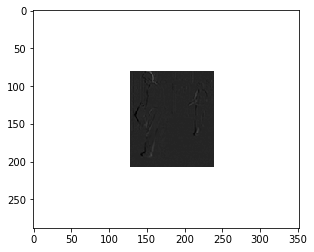

In [150]:
frame = imageReconstructFromBlocks(mc2)
plt.imshow(frame, cmap='gray')

In [117]:
neighs = []
for point in outs:
    if has_neighbor(point, outs):
        neighs.append(point)

In [146]:
return_range(outs)

[(5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (6, 12),
 (6, 13),
 (6, 14),
 (7, 8),
 (7, 9),
 (7, 10),
 (7, 11),
 (7, 12),
 (7, 13),
 (7, 14),
 (8, 8),
 (8, 9),
 (8, 10),
 (8, 11),
 (8, 12),
 (8, 13),
 (8, 14),
 (9, 8),
 (9, 9),
 (9, 10),
 (9, 11),
 (9, 12),
 (9, 13),
 (9, 14),
 (10, 8),
 (10, 9),
 (10, 10),
 (10, 11),
 (10, 12),
 (10, 13),
 (10, 14),
 (11, 8),
 (11, 9),
 (11, 10),
 (11, 11),
 (11, 12),
 (11, 13),
 (11, 14),
 (12, 8),
 (12, 9),
 (12, 10),
 (12, 11),
 (12, 12),
 (12, 13),
 (12, 14)]

In [118]:
neighs

[(3, 5), (5, 4), (4, 4), (2, 5), (3, 6)]

In [124]:
xs, ys = [val[0] for val in neighs], [val[1] for val in neighs]

In [129]:
min(ys)

4

In [133]:
for i in range(min(xs), max(xs)+1):
    for j in range(min(ys), max(ys)+1):
        print((i,j))

(2, 4)
(2, 5)
(2, 6)
(3, 4)
(3, 5)
(3, 6)
(4, 4)
(4, 5)
(4, 6)
(5, 4)
(5, 5)
(5, 6)
